In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm

from PIL import Image
from skimage.transform import resize
from skimage.util import img_as_ubyte, img_as_float
from sklearn.metrics import pairwise_distances
from utils import set_up_environment, prewhiten, maximum_center_crop, l2_normalize
from plot.heatmap import heatmap, annotate_heatmap
from plot.band_plot import line_bar_plot
from attacks.pgd import PGDAttacker

In [4]:
set_up_environment(visible_devices='0')

In [5]:
model_path = '../facenet_keras.h5'
model = tf.keras.models.load_model(model_path)

In [6]:
images = []
images_whitened = []
image_path = '../images/'
image_files = os.listdir(image_path)
image_files = [image_file for image_file in image_files if image_file.endswith('.png')]
for image_file in image_files:
    image = np.array(Image.open(os.path.join(image_path, image_file)))
    image = image[:, :, :3]
    image = maximum_center_crop(image)
    image = np.array(Image.fromarray(image).resize(size=(160, 160)))
    image = img_as_ubyte(image)
    image_whitened = prewhiten(image.astype(np.float32))

    images.append(image)
    images_whitened.append(image_whitened)

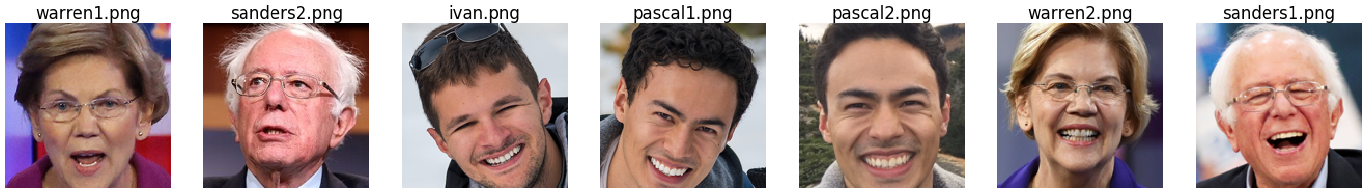

In [7]:
mpl.rcParams['figure.dpi'] = 50
fig, axs = plt.subplots(1, len(images), figsize=(5 * len(images), 5))
for i in range(len(images)):
    axs[i].imshow(images[i])
    axs[i].set_title(image_files[i], fontsize=24)
    axs[i].axis('off')

In [8]:
image_batch = tf.convert_to_tensor(np.array(images_whitened))

In [9]:
clean_embeddings = model.predict(image_batch)
clean_embeddings = l2_normalize(clean_embeddings)

In [10]:
attacker = PGDAttacker(model)

In [11]:
eps_vals = np.linspace(0.0, 0.1, 11)

In [12]:
perturbed_images = []
distance_arrays = []
for eps in tqdm(eps_vals):
    perturbed_image_batch = attacker.self_distance_attack(image_batch, epsilon=eps, verbose=False)
    perturbed_images.append(perturbed_image_batch)

    perturbed_embeddings = model.predict(perturbed_image_batch)
    perturbed_embeddings = l2_normalize(perturbed_embeddings)

    distances = np.zeros(len(image_batch))
    for i in range(len(image_batch)):
        distances[i] = np.sqrt(np.sum(np.square(clean_embeddings[i] - perturbed_embeddings[i])))

    distance_arrays.append(distances)

100%|██████████| 11/11 [12:43<00:00, 69.42s/it]


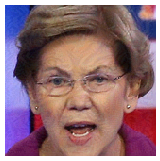

In [27]:
for i in range(6):
    plt.imshow(attacker._zero_one_norm(perturbed_images[i * 2][0]).numpy())
    plt.axis('off')
    plt.savefig('epsilon_{:.2f}.png'.format(eps_vals[i * 2]), bbox_inches='tight')

In [24]:
np.max(np.abs(attacker._zero_one_norm(perturbed_images[4][0]).numpy() - attacker._zero_one_norm(perturbed_images[0][0]).numpy()))

0.013132335

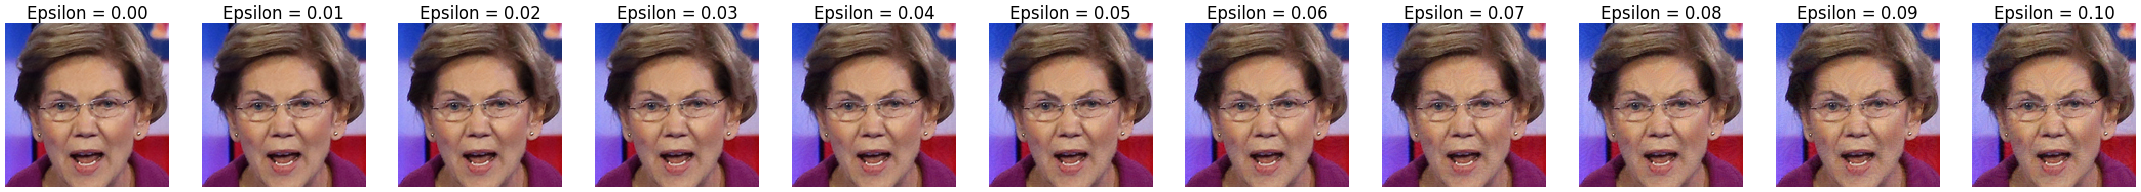

In [13]:
mpl.rcParams['figure.dpi'] = 50
fig, axs = plt.subplots(1, len(eps_vals), figsize=(5 * len(eps_vals), 5))
for i in range(len(eps_vals)):
    image = attacker._zero_one_norm(perturbed_images[i][0]).numpy()
    axs[i].imshow(image)
    axs[i].set_title('Epsilon = {:.2f}'.format(eps_vals[i]), fontsize=24)
    axs[i].axis('off')

In [14]:
data = pd.DataFrame(np.array(distance_arrays))
data['epsilon'] = eps_vals
data = pd.melt(data, var_name='face_id', value_name='self_distance', id_vars=['epsilon'])

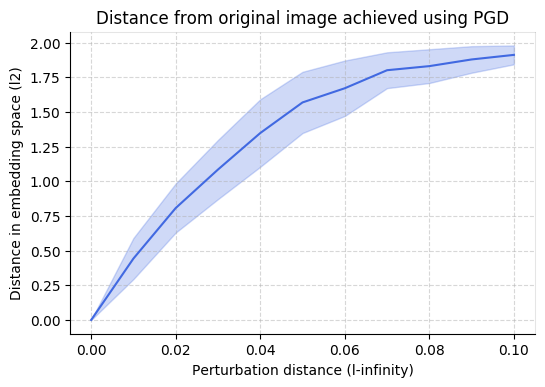

In [15]:
fig, ax = line_bar_plot(x='epsilon',
                        y='self_distance',
                        data=data,
                        xlabel='Perturbation distance (l-infinity)',
                        ylabel='Distance in embedding space (l2)',
                        title='Distance from original image achieved using PGD')

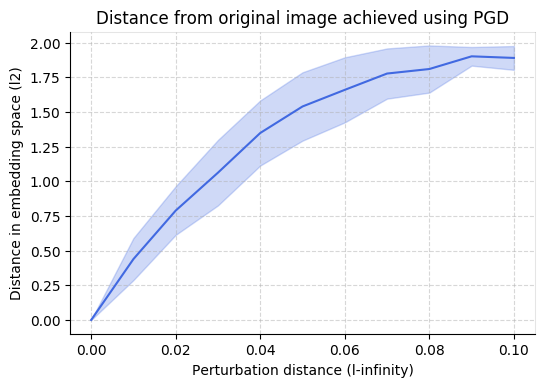

In [15]:
fig, ax = line_bar_plot(x='epsilon',
                        y='self_distance',
                        data=data,
                        xlabel='Perturbation distance (l-infinity)',
                        ylabel='Distance in embedding space (l2)',
                        title='Distance from original image achieved using PGD')

In [16]:
order = [1, 2, 3, 0, 5, 6, 4]
target_images = [images[i] for i in order]

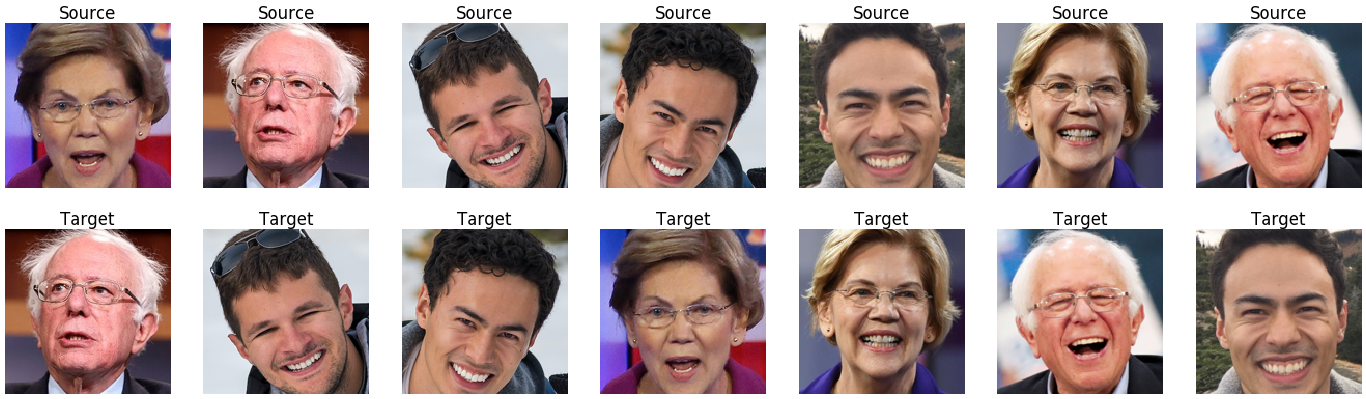

In [17]:
mpl.rcParams['figure.dpi'] = 50
fig, axs = plt.subplots(2, len(images), figsize=(5 * len(images), 10))
for i in range(len(images)):
    axs[0, i].imshow(images[i])
    axs[0, i].set_title('Source', fontsize=24)
    axs[0, i].axis('off')

    axs[1, i].imshow(target_images[i])
    axs[1, i].set_title('Target', fontsize=24)
    axs[1, i].axis('off')

In [18]:
targets_whitened = [prewhiten(image) for image in target_images]
target_batch = tf.convert_to_tensor(np.array(targets_whitened))

In [19]:
clean_embeddings = model.predict(image_batch)
clean_embeddings = l2_normalize(clean_embeddings)

In [20]:
target_embeddings = model.predict(target_batch)
target_embeddings = l2_normalize(target_embeddings)

In [21]:
perturbed_images = []
target_distance_arrays = []
self_distance_arrays = []

for eps in tqdm(eps_vals):
    perturbed_image_batch = attacker.target_image_attack(image_batch, target_batch, epsilon=eps)
    perturbed_images.append(perturbed_image_batch)

    perturbed_embeddings = model.predict(perturbed_image_batch)
    perturbed_embeddings = l2_normalize(perturbed_embeddings)

    self_distances = np.zeros(len(image_batch))
    target_distances = np.zeros(len(image_batch))

    for i in range(len(image_batch)):
        self_distances[i]   = np.sqrt(np.sum(np.square(clean_embeddings[i]  - perturbed_embeddings[i])))
        target_distances[i] = np.sqrt(np.sum(np.square(target_embeddings[i] - perturbed_embeddings[i])))

    self_distance_arrays.append(self_distances)
    target_distance_arrays.append(target_distances)

  0%|          | 0/11 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 11/11 [08:00<00:00, 43.70s/it]


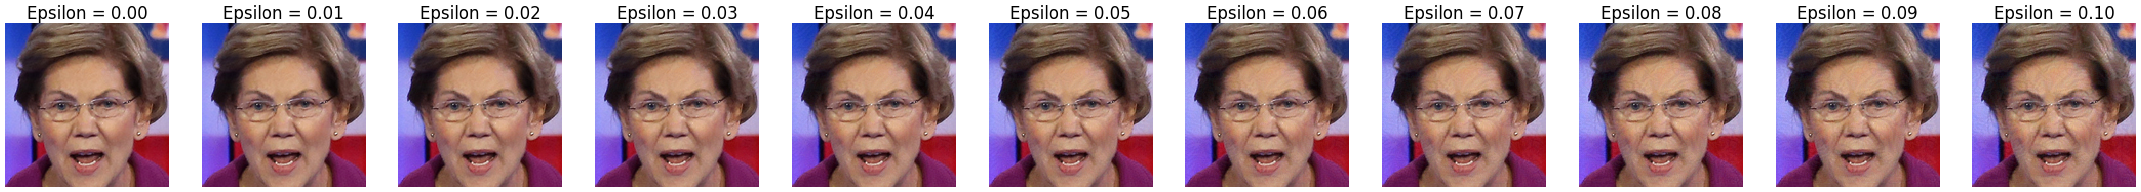

In [22]:
mpl.rcParams['figure.dpi'] = 50
fig, axs = plt.subplots(1, len(eps_vals), figsize=(5 * len(eps_vals), 5))
for i in range(len(eps_vals)):
    image = attacker._zero_one_norm(perturbed_images[i][0]).numpy()
    axs[i].imshow(image)
    axs[i].set_title('Epsilon = {:.2f}'.format(eps_vals[i]), fontsize=24)
    axs[i].axis('off')

In [23]:
self_distance_data = pd.DataFrame(np.array(self_distance_arrays))
self_distance_data['epsilon'] = eps_vals
self_distance_data = pd.melt(self_distance_data,
                             var_name='face_id',
                             value_name='self_distance',
                             id_vars=['epsilon'])

In [24]:
target_distance_data = pd.DataFrame(np.array(target_distance_arrays))
target_distance_data['epsilon'] = eps_vals
target_distance_data = pd.melt(target_distance_data,
                               var_name='face_id',
                               value_name='target_distance',
                               id_vars=['epsilon'])

In [ ]:
fig, ax = line_bar_plot(x='epsilon',
                        y='self_distance',
                        data=self_distance_data,
                        xlabel='Perturbation distance (l-infinity)',
                        ylabel='Distance in embedding space (l2)',
                        title='Distance from original image achieved using PGD with target image strategy')

In [ ]:
fig, ax = line_bar_plot(x='epsilon',
                        y='target_distance',
                        data=target_distance_data,
                        xlabel='Perturbation distance (l-infinity)',
                        ylabel='Distance in embedding space (l2)',
                        title='Distance from target image achieved using PGD with target image strategy')